In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 10.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import random as rd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_taranaki = pd.read_csv('/content/drive/MyDrive/Taranaki_PEF_clear.csv')
df_nopims = pd.read_csv('/content/drive/MyDrive/NOPIMS_clear.csv')

In [ ]:
df_taranaki = df_taranaki.rename(columns={'WELLNAME': 'UWI', 'DENS': 'RHOB'})

In [ ]:
df_taranaki.set_index(['UWI', 'DEPT'], inplace = True)
df_nopims.set_index(['UWI', 'DEPT'], inplace = True)

In [ ]:
df_taranaki = df_taranaki[['RHOB', 'DRHO', 'GR', 'PEF']]
df_nopims = df_nopims[['RHOB', 'DRHO', 'GR', 'PEF']]

In [ ]:
print(f'Количество скважин Taranaki = {df_taranaki.index.get_level_values(0).nunique()}')
print(f'Количество скважин Nopims = {df_nopims.index.get_level_values(0).nunique()}')

Количество скважин Taranaki = 115
Количество скважин Nopims = 20


In [ ]:
X_taranaki = df_taranaki.drop(['PEF'], axis = 1)
y_taranaki = df_taranaki['PEF']

X_nopims = df_nopims.drop(['PEF'], axis = 1)
y_nopims = df_nopims['PEF']

In [ ]:
df_X = pd.concat([X_taranaki, X_nopims])
df_y = pd.concat([y_taranaki, y_nopims])

In [ ]:
X = df_X.reset_index()
y = df_y.reset_index()

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

normalized_values_X = scaler_X.fit_transform(X[['RHOB', 'DRHO', 'GR']])
normalized_values_y = scaler_y.fit_transform(y[['PEF']])

X[['RHOB', 'DRHO', 'GR']] = normalized_values_X
y[['PEF']] = normalized_values_y

X_scaled = X.set_index(['UWI', 'DEPT'])
y_scaled = y.set_index(['UWI', 'DEPT'])

In [ ]:
X_taranaki = X_scaled.loc[X_taranaki.index.get_level_values(0).unique()]
y_taranaki = y_scaled.loc[y_taranaki.index.get_level_values(0).unique()]

X_nopims = X_scaled.loc[X_nopims.index.get_level_values(0).unique()]
y_nopims = y_scaled.loc[y_nopims.index.get_level_values(0).unique()]

In [ ]:
train_part_size = 0.7

rd.seed(16)
train_wells_taranaki = rd.sample(
    X_taranaki.index.get_level_values(0).unique().tolist(),
    round(len(X_taranaki.index.get_level_values(0).unique()) * train_part_size),
)

val_wells_taranaki = list(set(X_taranaki.index.get_level_values(0).unique().tolist()) - set(train_wells_taranaki))
val_wells_taranaki = sorted(val_wells_taranaki)
rd.shuffle(val_wells_taranaki)

In [ ]:
rd.seed(12)
train_wells_nopims = rd.sample(
    X_nopims.index.get_level_values(0).unique().tolist(),
    round(len(X_nopims.index.get_level_values(0).unique()) * train_part_size),
)

val_test_wells_nopims = list(set(X_nopims.index.get_level_values(0).unique().tolist()) - set(train_wells_nopims))
val_test_wells_nopims = sorted(val_test_wells_nopims)
rd.shuffle(val_test_wells_nopims)

rd.seed(12)
val_wells_nopims = rd.sample(
    val_test_wells_nopims,
    round(len(val_test_wells_nopims) * 0.5),)

test_wells_nopims = list(set(val_test_wells_nopims) - set(val_wells_nopims))
test_wells_nopims = sorted(test_wells_nopims)
rd.shuffle(test_wells_nopims)

In [ ]:
train_X_taranaki = X_taranaki.loc[train_wells_taranaki]
train_y_taranaki = y_taranaki.loc[train_wells_taranaki]

val_X_taranaki = X_taranaki.loc[val_wells_taranaki]
val_y_taranaki = y_taranaki.loc[val_wells_taranaki]

In [ ]:
train_X_nopims = X_nopims.loc[train_wells_nopims]
train_y_nopims = y_nopims.loc[train_wells_nopims]

val_X_nopims = X_nopims.loc[val_wells_nopims]
val_y_nopims = y_nopims.loc[val_wells_nopims]

test_X_nopims = X_nopims.loc[test_wells_nopims]
test_y_nopims = y_nopims.loc[test_wells_nopims]

In [ ]:
def gen_data_per_well(features, target, time_steps=50):
    Xs, ys = [], []

    # Перебираем уникальные значения скважин
    for well_name in features.index.get_level_values('UWI').unique():
        # Получаем данные для текущей скважины
        well_features = features.xs(well_name, level='UWI')
        well_target = target.xs(well_name, level='UWI')

        # Генерируем X и y для текущей скважины
        for i in range(len(well_features) - time_steps):
            Xs.append(well_features.iloc[i:i + time_steps].values)
            ys.append(well_target.iloc[i + time_steps - 1])

    return np.array(Xs), np.array(ys)

In [ ]:
train_X_taranaki, train_y_taranaki = gen_data_per_well(train_X_taranaki, train_y_taranaki)
val_X_taranaki, val_y_taranaki = gen_data_per_well(val_X_taranaki, val_y_taranaki)

In [ ]:
train_X_nopims, train_y_nopims = gen_data_per_well(train_X_nopims, train_y_nopims)
val_X_nopims, val_y_nopims = gen_data_per_well(val_X_nopims, val_y_nopims)
test_X_nopims, test_y_nopims = gen_data_per_well(test_X_nopims, test_y_nopims)

In [ ]:
train_X_taranaki_tensor = torch.tensor(train_X_taranaki, dtype=torch.float32)
train_y_taranaki_tensor = torch.tensor(train_y_taranaki, dtype=torch.float32)

val_X_taranaki_tensor = torch.tensor(val_X_taranaki, dtype=torch.float32)
val_y_taranaki_tensor = torch.tensor(val_y_taranaki, dtype=torch.float32)

In [ ]:
train_X_nopims_tensor = torch.tensor(train_X_nopims, dtype=torch.float32)
train_y_nopims_tensor = torch.tensor(train_y_nopims, dtype=torch.float32)

val_X_nopims_tensor = torch.tensor(val_X_nopims, dtype=torch.float32)
val_y_nopims_tensor = torch.tensor(val_y_nopims, dtype=torch.float32)

test_X_nopims_tensor = torch.tensor(test_X_nopims, dtype=torch.float32)
test_y_nopims_tensor = torch.tensor(test_y_nopims, dtype=torch.float32)

In [ ]:
# Создание TensorDataset
train_dataset_taranaki = TensorDataset(train_X_taranaki_tensor, train_y_taranaki_tensor)
val_dataset_taranaki = TensorDataset(val_X_taranaki_tensor, val_y_taranaki_tensor)

# Создание DataLoader
train_loader_taranaki = DataLoader(train_dataset_taranaki, batch_size=128, shuffle=True)
val_loader_taranaki = DataLoader(val_dataset_taranaki, batch_size=128, shuffle=False)

In [ ]:
# Создание TensorDataset
train_dataset_nopims = TensorDataset(train_X_nopims_tensor, train_y_nopims_tensor)
val_dataset_nopims = TensorDataset(val_X_nopims_tensor, val_y_nopims_tensor)
test_dataset_nopims = TensorDataset(test_X_nopims_tensor, test_y_nopims_tensor)

# Создание DataLoader
train_loader_nopims = DataLoader(train_dataset_nopims, batch_size=64, shuffle=True)
val_loader_nopims = DataLoader(val_dataset_nopims, batch_size=64, shuffle=False)
test_loader_nopims = DataLoader(test_dataset_nopims, batch_size=64, shuffle=False)

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=256, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm1d(256)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=5, padding='same')
        self.bn2 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=2, padding='same')
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        self.lstm1 = nn.LSTM(input_size=256, hidden_size=128, batch_first=True)
        self.dropout1 = nn.Dropout(0.267619)

        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Теперь x имеет форму (batch_size, features_dim, time_steps)
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = nn.ReLU()(x)
        x = self.pool3(x)

        # Сначала нужно изменить размерность для LSTM
        x = x.transpose(1, 2)  # Меняем местами размерности (batch_size, num_channels, sequence_length) -> (batch_size, sequence_length, num_channels)

        x, _ = self.lstm1(x)
        x = self.dropout1(x)

        # Берем только последний выход LSTM
        x = x[:, -1, :]  # (batch_size, hidden_size)

        x = self.fc(x)

        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train(model, train_loader, val_loader, optimizer, criterion, num_epochs, patience=4, lr_reduce_factor=0.5):
    model.to(device)  # Перемещаем модель на GPU

    best_val_loss = float('inf')  # Наименьшая валидационная потеря
    epochs_without_improvement = 0  # Счетчик эпох без улучшения
    best_weights = None  # Переменная для хранения лучших весов

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # В режим тренировки
        train_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Перемещаем данные на GPU
            optimizer.zero_grad()  # Обнуляем градиенты
            outputs = model(inputs)  # Прямой проход
            loss = criterion(outputs, targets)  # Вычисление потерь
            loss.backward()  # Обратный проход
            optimizer.step()  # Обновление весов

            train_loss += loss.item()  # Суммируем потери для тренировки

        train_loss /= len(train_loader)  # Среднее значение по всем батчам
        train_losses.append(train_loss)

        # Валидация
        model.eval()  # В режим валидации
        val_loss = 0.0
        with torch.no_grad():  # Отключаем градиенты
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Перемещаем данные на GPU
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)  # Среднее значение по всем батчам
        val_losses.append(val_loss)

        # Если текущая валидационная потеря лучше, сохраняем веса
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = model.state_dict()  # Сохраняем лучшие веса
            epochs_without_improvement = 0  # Сбрасываем счетчик
        else:
            epochs_without_improvement += 1  # Увеличиваем счетчик без улучшений

        # Изменяем скорость обучения, если не было улучшения
        if epochs_without_improvement > 0 and epochs_without_improvement % 2 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= lr_reduce_factor  # Уменьшаем lr в 2 раза

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Проверяем, нужно ли остановить обучение
        if epochs_without_improvement >= patience:
            print(f'Stopping early at epoch {epoch + 1}. Best Val Loss: {best_val_loss:.4f}')
            break

    # Восстанавливаем лучшие веса
    if best_weights is not None:
        model.load_state_dict(best_weights)
        print("Loaded best weights.")

    return train_losses, val_losses

In [ ]:
def get_predictions(model, test_loader, device):
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            predictions.append(outputs.cpu().numpy())
            true_values.append(batch_y.cpu().numpy())
    predictions = np.concatenate(predictions)
    true_values = np.concatenate(true_values)
    return predictions, true_values

In [ ]:
def objective(trial):
    # Для каждой итерации вы будете брать значение скорости обучения из Optuna
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-4)  # Определите диапазон для lr

    model = MyModel()

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Обучаем модель
    train_losses, val_losses = train(model, train_loader_taranaki, val_loader_taranaki, optimizer, criterion, num_epochs=50)

    predictions, true_values = get_predictions(model, val_loader_taranaki, device)

    r2 = r2_score(true_values, predictions)

    return r2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

In [ ]:
print("Лучшие гиперпараметры:", study.best_params)
print("Лучшее значение R^2:", study.best_value)

In [ ]:
model = MyModel()
optimizer = optim.Adam(model.parameters(), lr=0.00002)
criterion = nn.MSELoss()

In [ ]:
train_losses, val_losses = train(model, train_loader_taranaki, val_loader_taranaki, optimizer, criterion, num_epochs=50)

Epoch 1/50, Train Loss: 0.0004, Val Loss: 0.0002
Epoch 2/50, Train Loss: 0.0001, Val Loss: 0.0002
Epoch 3/50, Train Loss: 0.0001, Val Loss: 0.0002
Epoch 4/50, Train Loss: 0.0001, Val Loss: 0.0002
Epoch 5/50, Train Loss: 0.0001, Val Loss: 0.0002
Epoch 6/50, Train Loss: 0.0001, Val Loss: 0.0002
Epoch 7/50, Train Loss: 0.0001, Val Loss: 0.0002
Epoch 8/50, Train Loss: 0.0001, Val Loss: 0.0002
Stopping early at epoch 8. Best Val Loss: 0.0002
Loaded best weights.


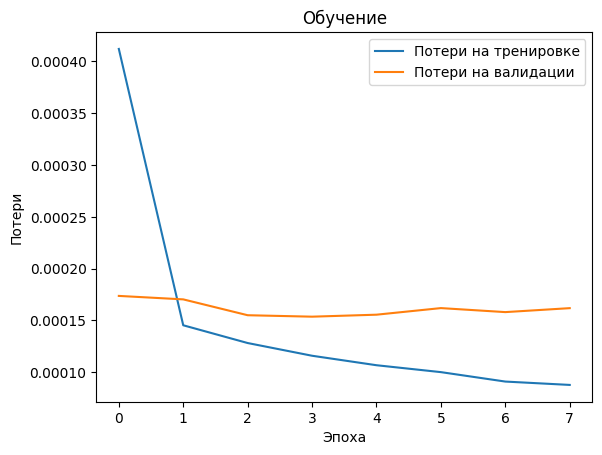

In [ ]:
plt.plot(train_losses, label='Потери на тренировке')
plt.plot(val_losses, label='Потери на валидации')
plt.title('Обучение')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

In [ ]:
torch.save(model, 'model_taranaki.pth')

In [ ]:
pretrained_model = torch.load('model_taranaki.pth', weights_only=False)

In [ ]:
class MyModel_2(nn.Module):
    def __init__(self):
        super(MyModel_2, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=256, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm1d(256)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=5, padding='same')
        self.bn2 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=2, padding='same')
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        self.lstm1 = nn.LSTM(input_size=256, hidden_size=128, batch_first=True)
        self.dropout1 = nn.Dropout(0.267619)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Теперь x имеет форму (batch_size, features_dim, time_steps)
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = nn.ReLU()(x)
        x = self.pool3(x)

        # Сначала нужно изменить размерность для LSTM
        x = x.transpose(1, 2)  # Меняем местами размерности (batch_size, num_channels, sequence_length) -> (batch_size, sequence_length, num_channels)

        x, _ = self.lstm1(x)
        x = self.dropout1(x)

        return x[:, -1, :]

# Определение нового класса FeatureExtractor
class FeatureExtractor(nn.Module):
    def __init__(self, pretrained_model):
        super(FeatureExtractor, self).__init__()
        self.pretrained_model = pretrained_model

        # Замораживаем слои предобученной модели
        for param in self.pretrained_model.parameters():
            param.requires_grad = False

        # Новый LSTM слой перед полносвязными слоями
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.dropout2 = nn.Dropout(p=0.3346)  # Dropout слой для регуляризации

        self.lstm3 = nn.LSTM(input_size=128, hidden_size=32, batch_first=True)
        self.dropout3 = nn.Dropout(p=0.0891)  # Dropout слой для регуляризации

        # Добавление своих полносвязных слоев
        self.fc1 = nn.Linear(32, 64)     # Первый полносвязный слой
        self.dropout4 = nn.Dropout(p=0.0979)  # Dropout для регуляризации
        self.fc2 = nn.Linear(64, 64)     # Второй полносвязный слой
        self.dropout5 = nn.Dropout(p=0.0526)  # Второй Dropout
        self.fc3 = nn.Linear(64, 1)      # Финальный выходной слой

    def forward(self, x):
        # Извлечение признаков из предобученной модели
        features = self.pretrained_model(x)

        # Применение нового LSTM слоя к извлеченным признакам
        features = features.unsqueeze(1)  # Добавление размерности для LSTM
        lstm_output, _ = self.lstm2(features)
        lstm_output = self.dropout2(lstm_output)

        lstm_output, _ = self.lstm3(lstm_output)
        lstm_output = self.dropout3(lstm_output)

        # Берем только последний выход LSTM
        lstm_output = lstm_output[:, -1, :]  # (batch_size, hidden_size)

        # Применяем свои полносвязные слои с Dropout и активацией
        x = self.fc1(lstm_output)
        x = nn.ReLU()(x)
        x = self.dropout4(x)

        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.dropout5(x)

        output = self.fc3(x)
        return output

# Загрузка подготовленной модели
pretrained_model_path = 'model_taranaki.pth'
pretrained_model = MyModel_2()

# Загрузка весов
pretrained_weights = torch.load(pretrained_model_path, weights_only=False)

# Создаем экземпляр FeatureExtractor
feature_extractor = FeatureExtractor(pretrained_model)

# Проверка структуры загруженной модели
print(feature_extractor)

FeatureExtractor(
  (pretrained_model): MyModel_2(
    (conv1): Conv1d(3, 256, kernel_size=(3,), stride=(1,), padding=same)
    (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=same)
    (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv1d(256, 256, kernel_size=(2,), stride=(1,), padding=same)
    (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (lstm1): LSTM(256, 128, batch_first=True)
    (dropout1): Dropout(p=0.267619, inplace=False)
  )
  (lstm2): LSTM(128, 128, batch_first=True)
  (dropout2): Dropout(p=0.3346, inplace=F

In [ ]:
for name, param in feature_extractor.named_parameters():
    if param.requires_grad:
        print(name)

lstm2.weight_ih_l0
lstm2.weight_hh_l0
lstm2.bias_ih_l0
lstm2.bias_hh_l0
lstm3.weight_ih_l0
lstm3.weight_hh_l0
lstm3.bias_ih_l0
lstm3.bias_hh_l0
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias


In [ ]:
def objective(trial):
    # Предлагаем параметры для оптимизации
    lstm_hidden_size = trial.suggest_int('lstm_hidden_size', 64, 256)
    dropout_rate1 = trial.suggest_float('dropout_rate1', 0.01, 0.5)
    dropout_rate2 = trial.suggest_float('dropout_rate2', 0.01, 0.5)
    dropout_rate3 = trial.suggest_float('dropout_rate3', 0.01, 0.5)
    fc1_units = trial.suggest_int('fc1_units', 32, 128)
    fc2_units = trial.suggest_int('fc2_units', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-7, 1e-3, log=True)

    # Создаем модель с предложенными параметрами
    feature_extractor = FeatureExtractor(pretrained_model)
    feature_extractor.lstm2 = nn.LSTM(input_size=128, hidden_size=lstm_hidden_size, batch_first=True)
    feature_extractor.dropout2 = nn.Dropout(p=dropout_rate1)
    feature_extractor.lstm3 = nn.LSTM(input_size=lstm_hidden_size, hidden_size=32, batch_first=True)
    feature_extractor.dropout3 = nn.Dropout(p=dropout_rate2)
    feature_extractor.fc1 = nn.Linear(32, fc1_units)
    feature_extractor.dropout4 = nn.Dropout(p=dropout_rate3)
    feature_extractor.fc2 = nn.Linear(fc1_units, fc2_units)
    feature_extractor.fc3 = nn.Linear(fc2_units, 1)

    # Перемещаем модель на устройство (GPU или CPU)
    feature_extractor.to(device)

    # Определяем оптимизатор и функцию потерь
    optimizer = optim.Adam(feature_extractor.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Обучение модели
    train_losses, val_losses = train(feature_extractor, train_loader_nopims, val_loader_nopims, optimizer, criterion, num_epochs=50)

    predictions, true_values = get_predictions(feature_extractor, test_loader_nopims, device)

    r2 = r2_score(true_values, predictions)

    return r2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

In [ ]:
print("Лучшие гиперпараметры:", study.best_params)
print("Лучшее значение R^2:", study.best_value)

In [ ]:
model = FeatureExtractor(pretrained_model)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [ ]:
train_losses, val_losses = train(model, train_loader_nopims, val_loader_nopims, optimizer, criterion, num_epochs=50)

Epoch 1/50, Train Loss: 0.0049, Val Loss: 0.0014
Epoch 2/50, Train Loss: 0.0025, Val Loss: 0.0008
Epoch 3/50, Train Loss: 0.0022, Val Loss: 0.0007
Epoch 4/50, Train Loss: 0.0020, Val Loss: 0.0005
Epoch 5/50, Train Loss: 0.0019, Val Loss: 0.0006
Epoch 6/50, Train Loss: 0.0018, Val Loss: 0.0005
Epoch 7/50, Train Loss: 0.0017, Val Loss: 0.0004
Epoch 8/50, Train Loss: 0.0017, Val Loss: 0.0005
Epoch 9/50, Train Loss: 0.0016, Val Loss: 0.0005
Epoch 10/50, Train Loss: 0.0016, Val Loss: 0.0004
Epoch 11/50, Train Loss: 0.0015, Val Loss: 0.0004
Epoch 12/50, Train Loss: 0.0015, Val Loss: 0.0004
Epoch 13/50, Train Loss: 0.0015, Val Loss: 0.0004
Epoch 14/50, Train Loss: 0.0015, Val Loss: 0.0005
Epoch 15/50, Train Loss: 0.0015, Val Loss: 0.0004
Stopping early at epoch 15. Best Val Loss: 0.0004
Loaded best weights.


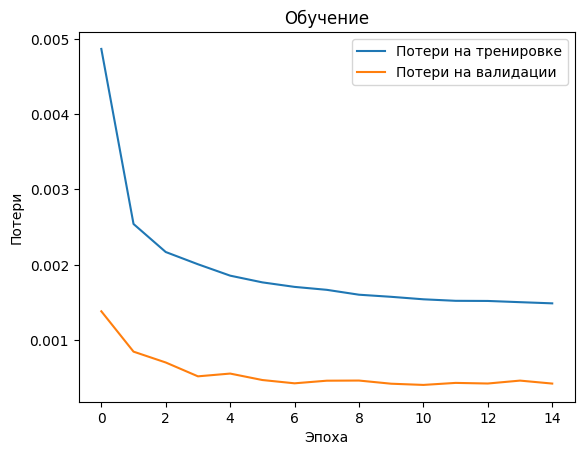

In [ ]:
plt.plot(train_losses, label='Потери на тренировке')
plt.plot(val_losses, label='Потери на валидации')
plt.title('Обучение')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

In [ ]:
predictions, true_values = get_predictions(model, test_loader_nopims, device)

In [ ]:
mae = mean_absolute_error(true_values, predictions)
mape = mean_absolute_percentage_error(true_values, predictions)
rmse = root_mean_squared_error(true_values, predictions)
r2 = r2_score(true_values, predictions)

In [ ]:
print(f"MAE: {mae}",
      f"MAPE: {mape}",
      f"RMSE: {rmse}",
      f"R2: {r2}", sep = '\n')

MAE: 0.010111246994844628
MAPE: 0.20371373073575547
RMSE: 0.02640815634158464
R2: 0.9063884477504677


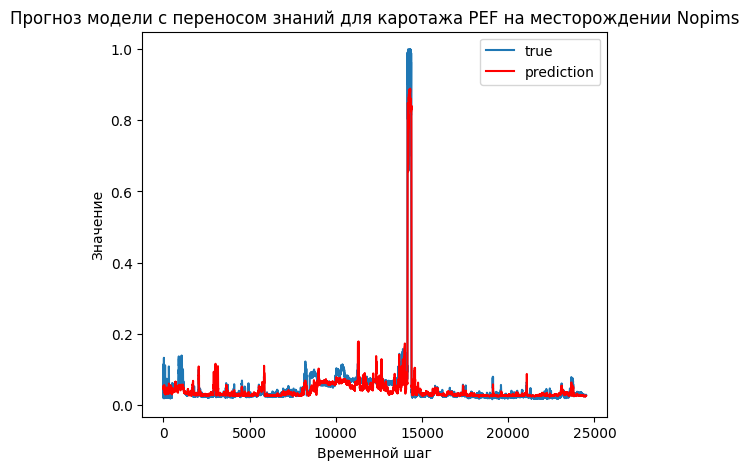

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(true_values, label="true")
plt.plot(predictions, 'r', label="prediction")
plt.title('Прогноз модели с переносом знаний для каротажа PEF на месторождении Nopims')
plt.ylabel('Значение')
plt.xlabel('Временной шаг')
plt.legend()
plt.show()

In [ ]:
np.save('trans_pred_1.npy', predictions)

In [ ]:
for i in range(9):
    print(f"\nTraining iteration {i + 1}/9")

    # Создаем новую модель и оптимизатор для каждой итерации
    model = FeatureExtractor(pretrained_model)

    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.MSELoss()

    # Обучаем модель
    train_losses, val_losses = train(model, train_loader_nopims, val_loader_nopims, optimizer, criterion, num_epochs=50)

    # Получаем предсказания на тестовом наборе
    predictions, _ = get_predictions(model, test_loader_nopims, device)

    # Сохраняем предсказания текущей итерации
    np.save(f'trans_pred_{i + 2}.npy', predictions)